In [1]:
import os

 # Set the working directory to Desktop
os.chdir(r"C:\Users\MonsuratAyinde\Desktop\data_multiclass")

# Confirm the change
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\MonsuratAyinde\Desktop\data_multiclass


In [2]:
import os
import sys
from collections import Counter

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from tqdm.version import __version__ as tqdm__version__

torch.backends.cudnn.deterministic = True

we'll print out the version numbers for our libraries, including Python. We want to make sure that anyone who reviews our work knows exactly what software we used in case they want to reproduce our analysis.

In [3]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("CV2 version : ", cv2.__version__)
print("matplotlib version : ", matplotlib.__version__)
print("numpy version : ", np.__version__)
print("torch version : ", torch.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("torchvision version : ", torchvision.__version__)
print("PIL version : ", PIL.__version__)
print("scikit-learn version: ", sklearn.__version__)
print("tqdm version: ", tqdm__version__)

Platform: win32
Python version: 3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:14) [MSC v.1929 64 bit (AMD64)]
---
CV2 version :  4.11.0
matplotlib version :  3.10.0
numpy version :  2.2.4
torch version :  2.7.0+cpu
torchinfo version :  1.8.0
torchvision version :  0.22.0+cpu
PIL version :  11.1.0
scikit-learn version:  1.6.1
tqdm version:  4.67.1


In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [5]:
data_dir = os.path.join("data_binary")
train_dir = os.path.join(data_dir, "train")

print("Data Directory:", data_dir)
print("Training Data Directory:", train_dir)

Data Directory: data_binary
Training Data Directory: data_binary\train


Since we're doing binary classification, we'll have two different labels. The data for each label is separated into their own folder. The name of the folder corresponds to the name of the label.

In [6]:
 # import os
 # print("Current working directory:", os.getcwd())


In [7]:
labels = os.listdir(train_dir)
labels

['blank', 'hog']

# count blank images

In [8]:
hog_path = os.path.join(train_dir,"hog")
hog_images = os.listdir(hog_path)
print("leghth of hog images: ", len(hog_images))
blank_path = os.path.join(train_dir, "blank")
blank_images = os.listdir(blank_path)
print("length of blank images: ", len(blank_images))

leghth of hog images:  978
length of blank images:  2213


# Image path display

Display the path of one image of the blank class.

In [9]:
hog_image_name = hog_images[0]
print(hog_image_name)

hog_image_path = os.path.join(hog_path, hog_image_name)
print(hog_image_path)

blank_image_name = blank_images[0]
print(blank_image_name)

blank_image_path = os.path.join(blank_path, blank_image_name)
print(blank_image_path)

ZJ000005.jpg
data_binary\train\hog\ZJ000005.jpg
ZJ000013.jpg
data_binary\train\blank\ZJ000013.jpg


# print out the mode and size for the blank image sample

In [10]:
hog_img_pil = Image.open(hog_image_path)
print("Hog image: ", hog_img_pil.mode, hog_img_pil.size)

blank_img_pil = Image.open(blank_image_path)
print("Blank image: ", blank_img_pil.mode, blank_img_pil.size)

Hog image:  RGB (960, 540)
Blank image:  RGB (960, 540)


In [11]:
pixels = hog_img_pil.load()
print(pixels[0, 0])  # Sample pixel value at top-left


(22, 22, 22)


In [12]:
hog_img_gray = hog_img_pil.convert("L")
hog_img_gray.show()


# Prepare the Data

In [13]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [14]:
# Define transformation to apply to the images
transform = transforms.Compose(
    [
        ConvertToRGB(),  # Convert images to RGB format if not already
        transforms.Resize((224, 224)),  # Resize images to 224x224
        # Convert images to tensors
        transforms.ToTensor()

    ]
)

print(type(transform))
print(transform)

<class 'torchvision.transforms.transforms.Compose'>
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [15]:
# Load the dataset using `ImageFolder`
dataset = datasets.ImageFolder(root=train_dir, transform=transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 3191
    Root location: data_binary\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [16]:
dataset.classes

['blank', 'hog']

In [17]:
im = dataset.imgs
print(im[0])

distinct_classes = {x[1] for x in im}
print(distinct_classes)

('data_binary\\train\\blank\\ZJ000013.jpg', 0)
{0, 1}


In [18]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

# Print out the length of the validation dataset and the training dataset

In [19]:
print(f"Length of training set: {len(train_dataset)}")
print(f"Length of validation set: {len(val_dataset)}")


Length of training set: 2553
Length of validation set: 638


# Validation data plot

In [20]:
# !pip install ipywidgets --upgrade
# !jupyter nbextension enable --py widgetsnbextension --sys-prefix
# !jupyter nbextension install --py widgetsnbextension --sys-prefix


In [21]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [22]:
train_counts = class_counts(train_dataset)
train_counts

  0%|          | 0/2553 [00:00<?, ?it/s]

blank    1749
hog       804
dtype: int64

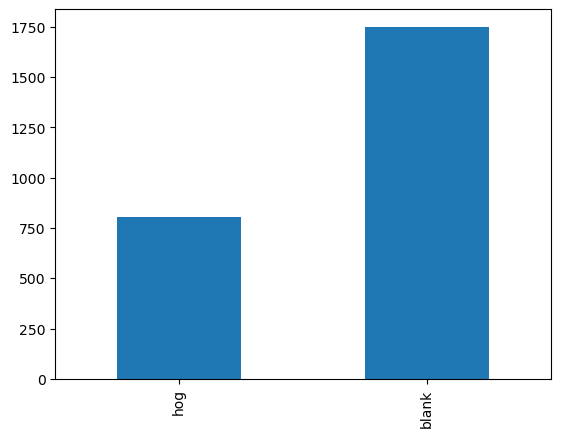

In [23]:
train_counts.sort_values().plot(kind="bar");

  0%|          | 0/638 [00:00<?, ?it/s]

<Axes: >

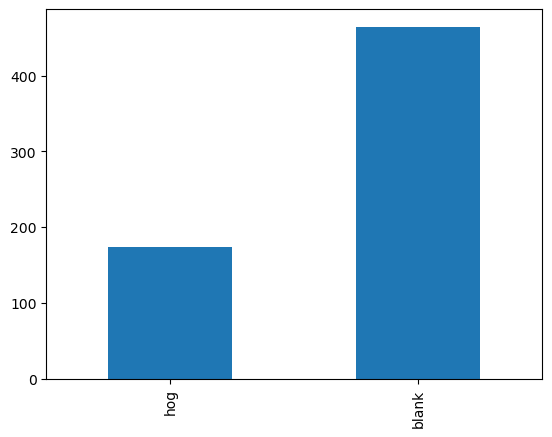

In [24]:
val_counts = class_counts(val_dataset)

# Make a bar chart from the function output
val_counts.sort_values().plot(kind="bar")

 From both visualizations, we see two things:

About two-thirds of the data is the "blank" label.
Both the training and validation set are similarly distributed.

# Create the validation loader.

In [25]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


# Building a shallow neural network

In [26]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# This gives you [batch_size, channels, height, width] for images
image_shape = images.shape
print("Shape of batch of images", image_shape)

# This gives you [batch_size] for labels
label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 3, 224, 224])
Shape of batch of labels: torch.Size([32])


In [27]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 1])

In [28]:
flatten = nn.Flatten()
tensor_flatten = flatten(images)

# Print the shape of the flattened tensor
print(f"shape of flattened tensor:{tensor_flatten.shape}")

shape of flattened tensor:torch.Size([32, 150528])


In [29]:
# Image size from our transformer
height = 224
width = 224

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * height * width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
)

print("model type:", type(model))
print("model structure:")
print(model)

model type: <class 'torch.nn.modules.container.Sequential'>
model structure:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
)


In [30]:
# create the Output layer

output_layer = nn.Linear(128, 2)
model.append(output_layer)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)


We can see three different types of layers being used:

nn.Flatten flattens the three-dimensional input tensors to the one-dimensional tensors that the next layers expect.
nn.Linear is a standard dense, or fully-connected, layer. It takes two arguments, the number of inputs coming into this layer and the number of outputs produced by this layer.
nn.ReLU performs the rectified linear unit activation. Activation functions are necessary for neural networks to work, and ReLU is a popular choice.
The last nn.Linear is our output layer. It must have 128 inputs, to match the output of the preceding layer, and it must have 2 outputs to match the two classes. Note that there's no activation function applied after the output layer. This means that the outputs of this layer are the logits. Later on, these logits will be the input to a normalization function, called softmax in this case, that will turn the logits into probabilities.

# Training Our Model

# Epoch Loss Report

In [31]:
loss_fn = nn.CrossEntropyLoss()

In [32]:
# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

model: The PyTorch model we built with a specific architecture

optimizer: The optimizer that will be used to best adjust the model weights

loss_fn: The loss function that the optimizer is trying to minimize

data_loader: The DataLoader object for the training dataset that makes it easy to iterate over batches

device: The device where we're going to place the tensors

In [33]:
def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    # We'll report the loss function's average value at the end of the epoch.
    training_loss = 0.0

    # The train method simply sets the model in training mode. No training
    # has happened.
    model.train()

    # We iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        # Sets the gradients to zero. We need to do this every time.
        optimizer.zero_grad()

        # Unpack images (X) and labels (y) from the batch and add those
        # tensors to the specified device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # We make a forward pass through the network and obtain the logits.
        # With the logits, we can calculate our loss.
        output = model(inputs)
        loss = loss_fn(output, targets)

        # After calculating our loss, we calculate the numerical value of
        # the derivative of our loss function with respect to all the
        # trainable model weights. Once we have the gradients calculated,
        # we let the optimizer take a "step", in other words, update or
        # adjust the model weights.
        loss.backward()
        optimizer.step()

        # We increment the training loss for the current batch
        training_loss += loss.data.item() * inputs.size(0)

    # We calculate the training loss over the completed epoch
    return training_loss / len(data_loader.dataset)

In [34]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device)
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/80 [00:00<?, ?it/s]

The average loss during the training epoch was 3.48.


A nice feature of neural networks is that when we do another training run, it doesn't start training from scratch. In other words, training resumes from the current weights and continues to adjust the weights to improve the model's performance.

In [35]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device)
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/80 [00:00<?, ?it/s]

The average loss during the training epoch was 0.62.


# Validation prediction

In [36]:
def predict(model, data_loader, device="cpu"):
    # This tensor will store all of the predictions.
    all_probs = torch.tensor([]).to(device)

    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()

    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():

        # Again, we iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # The model produces the logits.  This softmax function turns the
            # logits into probabilities.  These probabilities are concatenated
            # into the `all_probs` tensor.
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

In [37]:
probabilities_train = predict(model, train_loader, device)
print(probabilities_train.shape)

Predicting:   0%|          | 0/80 [00:00<?, ?it/s]

torch.Size([2553, 2])


# Make a prediction for each row of the validation data.

In [38]:
len(train_loader.dataset)

2553

In [39]:
probabilities_val = predict(model, val_loader,device) 
print(probabilities_val.shape)

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([638, 2])


In [40]:
print(probabilities_train[0])

tensor([0.0935, 0.9065])


 We see two numbers here. The first is the probability that this image is of the first class ("blank") and the second is the probability that it's of the second class ("hog"). Because these are the only two possibilities, they should add up to one.



In [41]:
probabilities_train[0].sum()

tensor(1.)

# Initial precision display

# Make a prediction for each row of the validation data

In [42]:
probabilities_val[0]

tensor([0.5085, 0.4915])

# Probability summation

In [43]:
# Print the probabilities of the first row
probabilities_val[0]

tensor([0.5085, 0.4915])

In [44]:
total_probability = probabilities_val[0].sum()
print(f"Sum of probabilities: {total_probability.item()}")

Sum of probabilities: 1.0


# class label prediction

In [45]:
predictions_train = torch.argmax(probabilities_train, dim=1)

print(f"Predictions shape: {predictions_train.shape}")
print(f"First 10 predictions: {predictions_train[:10]}")

Predictions shape: torch.Size([2553])
First 10 predictions: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [46]:
predictions_val = torch.argmax(probabilities_val, dim=1)

print(f"Predictions shape: {predictions_val.shape}")
print(f"First 10 predictions: {predictions_val[:10]}")

Predictions shape: torch.Size([638])
First 10 predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])



We'll compare the training set predictions to the actual class labels for the training set. The torch.eq function will help with this. We'll find the fraction that are correct. This is the accuracy

In [47]:
targets_train = torch.cat([labels for _, labels in train_loader]).to(device)
is_correct_train = torch.eq(predictions_train, targets_train)
total_correct_train = torch.sum(is_correct_train).item()
accuracy_train = total_correct_train / len(train_loader.dataset)

print(f"Accuracy on the training data: {accuracy_train}")

Accuracy on the training data: 0.6118292205248727


# validation Accuracy

In [48]:
targets_val = torch.cat([labels for _, labels in val_loader]).to(device)
is_correct_val = torch.eq(predictions_val, targets_val)
total_correct_val = torch.sum(is_correct_val).item()
accuracy_val = total_correct_val/len(val_loader.dataset)

print(f"Accuracy on the validation data: {accuracy_val}")

Accuracy on the validation data: 0.822884012539185


# Accuracy Confirmation

In [49]:
def score(model, data_loader, loss_fn, device="cpu"):
    # Initialize the total loss (cross entropy) and the number of correct
    # predictions. We'll increment these values as we loop through the
    # data.
    total_loss = 0
    total_correct = 0

    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()

    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():
        # We iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # Calculating the loss function for this batch
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            # Calculating the correct predictions for this batch
            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    return total_loss / len(data_loader.dataset), total_correct / len(
        data_loader.dataset
    )

In [50]:
loss_train, accuracy_train = score(model, train_loader, loss_fn, device)
print(f"Training accuracy from score function: {accuracy_train}")

Scoring:   0%|          | 0/80 [00:00<?, ?it/s]

Training accuracy from score function: 0.8202115158636898


In [51]:
loss_val, accuracy_val = score(model, val_loader, loss_fn, device)
print(f"Validation accuracy from score function: {accuracy_val}")

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Validation accuracy from score function: 0.822884012539185


# Extended Epoch Training

In [52]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):

    for epoch in range(1, epochs + 1):
        # Run train_epoch once, and capture the training loss.
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Score the model on the validation data.
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)

        print(
            f"Epoch: {epoch}, Training Loss: {training_loss:.2f}, "
            f"Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}"
        )

In [53]:
train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device=device)

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.63, Validation Loss: 0.68, Validation Accuracy: 0.78


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.54, Validation Loss: 0.77, Validation Accuracy: 0.78


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.50, Validation Loss: 0.47, Validation Accuracy: 0.81


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.44, Validation Loss: 0.36, Validation Accuracy: 0.87


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.40, Validation Loss: 0.34, Validation Accuracy: 0.87


# Continue training the model for two more epochs.

In [54]:

train(model, optimizer, loss_fn, train_loader, val_loader, epochs=2, device=device)

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.36, Validation Loss: 0.35, Validation Accuracy: 0.86


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.35, Validation Loss: 0.29, Validation Accuracy: 0.91


In [55]:
# Load the pre-trained model with the following line

In [56]:
import os

# Make sure the directory exists
os.makedirs("model", exist_ok=True)




In [64]:
# Save the entire model after training
torch.save(model, "model/trained_model.pth")

In [65]:
model = torch.load("model/trained_model.pth", weights_only=False)

# Make a prediction for each image in the validation set.

In [66]:
probabilities_val = predict(model, val_loader, device)
predictions_val = torch.argmax(probabilities_val, dim = 1)
print(predictions_val[:10])

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


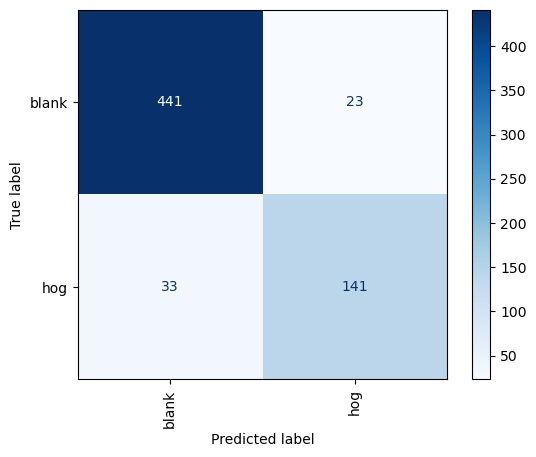

In [59]:
cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["blank", "hog"])

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

In [60]:
img_path = os.path.join(data_dir, "train/hog/ZJ000072.jpg")

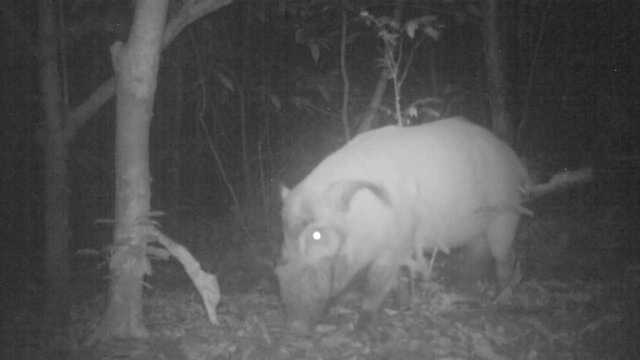

In [61]:
from IPython.display import Image as JupyterImage
JupyterImage(filename=img_path) 

In [62]:
labels = ["blank", "hog"]

img = Image.open(os.path.join(data_dir, "train/hog/ZJ000072.jpg"))
img = transform(img).to(device)
img = torch.unsqueeze(img, 0)

model.eval()
prediction = F.softmax(model(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction])

hog


In [63]:
F.softmax(model(img), dim=1)

tensor([[0.0187, 0.9813]], grad_fn=<SoftmaxBackward0>)